# A. Markovich, N. Puchkin
# Numerical experiments on synthetic data sets, described in the paper
# "Score-based change point detection via tracking the best of infinitely many experts"

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from numpy.random import normal as randn, multivariate_normal as randmn
from collections.abc import Iterable
from algorithms.score_based import *
%load_ext autoreload
%autoreload 2

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [17]:
def reference_score(x):
    if isinstance(x, (int, float)):
        return np.array([-x]).reshape(-1, 1)
    return -x.reshape(-1, 1)

In [18]:
# Auxiliary function for calculating average detection delay and the rate of false alarms

def compute_delays_false_alarms(runs, S_list, threshold, tau):
    delays = []
    false_alarms = 0
    not_detected = 0

    for i in range(runs):

        S = S_list[i]
        res = np.ma.flatnotmasked_edges(np.ma.masked_array(S, S <= threshold))
        if isinstance(res, Iterable):
            imin, _ = res
            if imin - tau <= 0:
                print(imin, i)
                false_alarms += 1
            else:
                delays.append(imin - tau)
        else:
            not_detected +=1

    if not_detected == runs or false_alarms == runs:
        return false_alarms, 0, 0, not_detected
    
    delays = np.array(delays)
    mean_delay = np.round(delays.mean(), 1)
    std_delay = np.round(delays.std(), 1)

    return false_alarms, mean_delay, std_delay, not_detected

## Example 1: mean shift detection in a univariate sequence.

### Score-based change point detector with linear basis $\Psi$

In [23]:
# function calculates the threshold and runs the algorithm with each set of hyperparameters in a loop
def train_params(eta_list, lambda_list, alpha_list):
    n = 300
    tau = 150
    runs = 10
    sigma = 0.2
    dim = 1

    np.random.seed(1)
    for eta in eta_list:
        for l in lambda_list:
            for a in alpha_list:
                
                # threshold 
                S_0 = np.empty((runs-1, tau))
                for item in range(runs-1):
                    X = sigma * randn(size=tau).reshape((tau, dim, 1))                
                    model = ChangePointDetector(d_dim=dim, x_dim=dim, lambda_=l, alpha=a, basis=PolyBasis(1, dim), reference_score=reference_score)
                    S, _ = model.run(X, eta)
                    S_0[item] = S
                threshold = np.round(np.max(S_0), 4)
                print('threshold = ', threshold)

                # detection of change points 
                S_list = np.empty((runs, n))
                for item in range(runs):
                    X = sigma * randn(size=n).reshape((n, dim, 1))      
                    X[tau:] += 2*sigma          
                    model = ChangePointDetector(d_dim=dim, x_dim=dim, lambda_=l, alpha=a, basis=PolyBasis(1, dim), reference_score=reference_score)
                    S, _ = model.run(X, eta)
                    S_list[item] = S

                # computation of average delays and the number of false alarms
                false_alarms, mean_delay, std_delay, not_detected = compute_delays_false_alarms(runs, S_list, threshold, tau)
                print(f'eta = {np.round(eta, 4)}, lambda = {np.round(l, 4)}, alpha = {np.round(a, 4)}', ' False alarms:', false_alarms, 'DD : ', mean_delay, '±', std_delay, 'not detected: ', not_detected)
    return S_list

In [1]:
S = train_params([0.001, 0.01, 0.1, 0.5, 1, 2, 5], [1, 2, 5, 10], [1e-3])

threshold =  0.0003
eta = 0.001, lambda = 1, alpha = 0.001  False alarms: 0 DD :  5.8 ± 3.8 not detected:  5
threshold =  0.0002
146 8
eta = 0.001, lambda = 2, alpha = 0.001  False alarms: 1 DD :  14.0 ± 3.6 not detected:  6
threshold =  0.0001
eta = 0.001, lambda = 5, alpha = 0.001  False alarms: 0 DD :  8.3 ± 1.2 not detected:  7
threshold =  0.0
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
2 9
eta = 0.001, lambda = 10, alpha = 0.001  False alarms: 10 DD :  nan ± nan not detected:  0
/var/folders/g6/yf_55rmd4s77kys7xw17p54m0000gn/T/ipykernel_24602/1433940887.py:24: RuntimeWarning: Mean of empty slice.
  mean_delay = np.round(delays.mean(), 1)
threshold =  0.0016
93 4
91 6
eta = 0.01, lambda = 1, alpha = 0.001  False alarms: 2 DD :  9.5 ± 4.4 not detected:  0
threshold =  0.0014
eta = 0.01, lambda = 2, alpha = 0.001  False alarms: 0 DD :  10.4 ± 10.2 not detected:  1
threshold =  0.0005
eta = 0.01, lambda = 5, alpha = 0.001  False alarms: 0 DD :  10.3 ± 6.9 not detected:  4
threshold =  0.0003

In [2]:
S = train_params([1], [10, 15], [8e-4, 1e-3, 5e-3])

threshold =  0.0026
eta = 1, lambda = 10, alpha = 0.0008  False alarms: 0 DD :  5.4 ± 3.0 not detected:  0
threshold =  0.0059
eta = 1, lambda = 10, alpha = 0.001  False alarms: 0 DD :  9.9 ± 1.5 not detected:  0
threshold =  0.0179
eta = 1, lambda = 10, alpha = 0.005  False alarms: 0 DD :  7.3 ± 2.1 not detected:  0
threshold =  0.0026
132 3
94 5
eta = 1, lambda = 15, alpha = 0.0008  False alarms: 2 DD :  6.9 ± 3.2 not detected:  0
threshold =  0.0025
74 4
50 6
eta = 1, lambda = 15, alpha = 0.001  False alarms: 2 DD :  6.4 ± 1.7 not detected:  0
threshold =  0.0223
eta = 1, lambda = 15, alpha = 0.005  False alarms: 0 DD :  7.1 ± 3.2 not detected:  0



In [3]:
S = train_params([1], [10, 11], [5e-4, 8e-4])

threshold =  0.0016
eta = 1, lambda = 10, alpha = 0.0005  False alarms: 0 DD :  5.3 ± 2.9 not detected:  0
threshold =  0.0048
eta = 1, lambda = 10, alpha = 0.0008  False alarms: 0 DD :  9.9 ± 1.5 not detected:  0
threshold =  0.0023
eta = 1, lambda = 11, alpha = 0.0005  False alarms: 0 DD :  8.1 ± 2.3 not detected:  0
threshold =  0.0027
94 5
eta = 1, lambda = 11, alpha = 0.0008  False alarms: 1 DD :  6.3 ± 2.9 not detected:  0



threshold =  0.001
eta = 1, lambda = 10, alpha = 0.0003  False alarms: 0 DD :  5.3 ± 2.9 not detected:  0


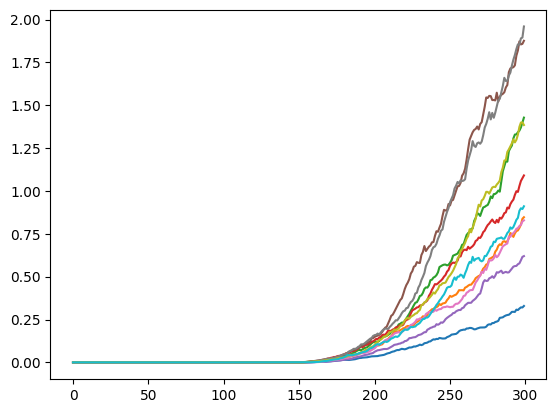

In [30]:
# final
S = train_params([1], [10], [3e-4]).T
plt.plot(S)
plt.show()

### Score-based change point detector with quadratic basis $\Psi$ 

In [6]:
# function calculates the threshold and runs the algorithm with each set of hyperparameters in a loop
def train_params(eta_list, lambda_list, alpha_list, thrs_ad=0):
    n = 300
    tau = 150
    runs = 10
    sigma = 0.2
    dim = 1

    np.random.seed(1)
    for eta in eta_list:
        for l in lambda_list:
            for a in alpha_list:
                
                # threshold 
                S_0 = np.empty((runs-1, tau))
                for item in range(runs-1):
                    X = sigma * randn(size=tau).reshape((tau, dim, 1))                
                    model = ChangePointDetector(d_dim=dim*2, x_dim=dim, lambda_=l, alpha=a, basis=PolyBasis(2, dim))
                    S, _ = model.run(X, eta)
                    S_0[item] = S
                threshold = np.max(S_0) + thrs_ad
                print('threshold = ', threshold)

                # detection of change points 
                S_list = np.empty((runs, n))
                for item in range(runs):
                    X = sigma * randn(size=n).reshape((n, dim, 1))      
                    X[tau:] += 2*sigma          
                    model = ChangePointDetector(d_dim=dim*2, x_dim=dim, lambda_=l, alpha=a, basis=PolyBasis(2, dim))
                    S, _ = model.run(X, eta)
                    S_list[item] = S
                    
                # computation of average delays and the number of false alarms
                false_alarms, mean_delay, std_delay, not_detected = compute_delays_false_alarms(runs, S_list, threshold, tau)
                print(f'eta = {np.round(eta, 4)}, lambda = {np.round(l, 4)}, alpha = {np.round(a, 5)}', ' False alarms:', false_alarms, 'DD : ', mean_delay, '±', std_delay, 'not detected: ', not_detected)

    return S_list

In [62]:
S = train_params([0.2], [0.3, 0.5, 0.7], [9e-5, 1e-4, 3e-4, 5e-4]).T

threshold =  96.44893718203275
eta = 0.2, lambda = 0.3, alpha = 9e-05  False alarms: 0 DD :  10.4 ± 4.7 not detected:  0
threshold =  64.08652915615176
eta = 0.2, lambda = 0.3, alpha = 0.0001  False alarms: 0 DD :  7.0 ± 2.3 not detected:  0
threshold =  82.07839342037596
eta = 0.2, lambda = 0.3, alpha = 0.0003  False alarms: 0 DD :  8.2 ± 0.7 not detected:  0
threshold =  141.6197277702288
eta = 0.2, lambda = 0.3, alpha = 0.0005  False alarms: 0 DD :  9.4 ± 3.4 not detected:  0
threshold =  35.35408362332305
eta = 0.2, lambda = 0.5, alpha = 9e-05  False alarms: 0 DD :  5.8 ± 3.5 not detected:  0
threshold =  50.37915375105513
95 1
eta = 0.2, lambda = 0.5, alpha = 0.0001  False alarms: 1 DD :  3.5 ± 1.1 not detected:  0
threshold =  71.12972650870358
eta = 0.2, lambda = 0.5, alpha = 0.0003  False alarms: 0 DD :  5.2 ± 2.5 not detected:  0
threshold =  36.670639339565355
eta = 0.2, lambda = 0.5, alpha = 0.0005  False alarms: 0 DD :  6.0 ± 1.4 not detected:  0
threshold =  50.84564029913

threshold =  10.719453640496454
eta = 0.2, lambda = 0.5, alpha = 8e-05  False alarms: 0 DD :  3.3 ± 1.8 not detected:  0


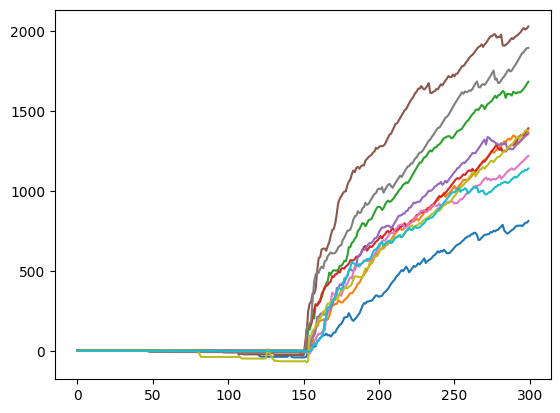

In [7]:
# final
S = train_params([0.2], [0.5], [8e-5]).T
plt.plot(S)
plt.show()

## Example 2: variance shift detection in a univariate sequence.

### Score-based change point detector with quadratic basis $\Psi$ 

In [13]:
# function calculates the threshold and runs the algorithm with each set of hyperparameters in a loop
def train_params(eta_list, lambda_list, alpha_list, thrs_add=0):
    n = 300
    tau = 150
    runs = 10
    sigma1 = 0.1
    sigma2 = 0.3
    dim = 1

    np.random.seed(1)
    for eta in eta_list:
        for l in lambda_list:
            for a in alpha_list:
                
                # threshold 
                S_0 = np.empty((runs-1, tau))
                for item in range(runs-1):
                    X = sigma1 * randn(size=tau).reshape((tau, dim, 1))                
                    model = ChangePointDetector(d_dim=dim*2, x_dim=1, lambda_=l, alpha=a, basis=PolyBasis(2, dim))
                    S, _ = model.run(X, eta)
                    S_0[item] = S
                threshold = np.max(S_0) + thrs_add
                print('threshold = ', threshold)

                # detection of change points 
                S_list = np.empty((runs, n))
                for item in range(runs):
                    X = randn(size=n).reshape((n, dim, 1))      
                    X[:tau] *= sigma1
                    X[tau:] *= sigma2        
                    model = ChangePointDetector(d_dim=dim*2, x_dim=1, lambda_=l, alpha=a, basis=PolyBasis(2, dim))
                    S, _ = model.run(X, eta)
                    S_list[item] = S
                    
                # computation of average delays and the number of false alarms
                false_alarms, mean_delay, std_delay, not_detected = compute_delays_false_alarms(runs, S_list, threshold, tau)
                print(f'eta = {np.round(eta, 4)}, lambda = {np.round(l, 4)}, alpha = {np.round(a, 5)}', ' False alarms:', false_alarms, 'DD : ', mean_delay, '±', std_delay, 'not detected: ', not_detected)
    return S_list, S_0

In [1]:
S = train_params([0.01, 0.05, 0.1, 0.3, 0.5, 0.7, 1], [0.8, 1, 1.5], [7e-5, 1e-4,3e-4]).T
plt.plot(S)
plt.show()


threshold =  55.03394774062852
150 8
eta = 0.3, lambda = 0.8, alpha = 0.0001  False alarms: 1 DD :  4.6 ± 3.3 not detected:  0
threshold =  22.306642151426583
eta = 0.3, lambda = 0.8, alpha = 0.0001  False alarms: 0 DD :  5.2 ± 3.4 not detected:  0
threshold =  22.849609948546256
eta = 0.3, lambda = 0.8, alpha = 0.0003  False alarms: 0 DD :  4.1 ± 2.5 not detected:  0
threshold =  0.17411665267925636
150 0
eta = 0.3, lambda = 1, alpha = 0.0001  False alarms: 1 DD :  3.1 ± 2.2 not detected:  0
threshold =  76.54995167304767
eta = 0.3, lambda = 1, alpha = 0.0001  False alarms: 0 DD :  5.0 ± 3.0 not detected:  0
threshold =  73.20691905987204
eta = 0.3, lambda = 1, alpha = 0.0003  False alarms: 0 DD :  3.1 ± 1.8 not detected:  0
threshold =  0.453120842728165
86 0
eta = 0.3, lambda = 1.5, alpha = 0.0001  False alarms: 1 DD :  3.6 ± 3.8 not detected:  0
threshold =  0.7456656879842536
140 0
125 6
eta = 0.3, lambda = 1.5, alpha = 0.0001  False alarms: 2 DD :  2.4 ± 2.1 not detected:  0
thre

In [10]:
S = train_params([0.7], [1], [1e-4])
S = train_params([0.7], [1.5], [1e-4])
S = train_params([0.6], [1.5], [1e-4])
S = train_params([0.5], [1.5], [1e-4])
S = train_params([0.4], [1.5], [1e-4])
S = train_params([0.3], [1.5], [1e-4])


eta = 0.7, lambda = 1, alpha = 0.0001  False alarms: 0 DD :  6.0 ± 4.7 not detected:  0
122 9
eta = 0.7, lambda = 1.5, alpha = 0.0001  False alarms: 1 DD :  5.1 ± 3.8 not detected:  0
122 9
eta = 0.6, lambda = 1.5, alpha = 0.0001  False alarms: 1 DD :  5.0 ± 3.4 not detected:  0
eta = 0.5, lambda = 1.5, alpha = 0.0001  False alarms: 0 DD :  4.4 ± 3.1 not detected:  0
122 9
eta = 0.4, lambda = 1.5, alpha = 0.0001  False alarms: 1 DD :  3.8 ± 2.8 not detected:  0
eta = 0.3, lambda = 1.5, alpha = 0.0001  False alarms: 0 DD :  4.0 ± 2.6 not detected:  0



threshold =  0.0
eta = 0.2, lambda = 1.5, alpha = 0.0001  False alarms: 0 DD :  3.3 ± 1.7 not detected:  0


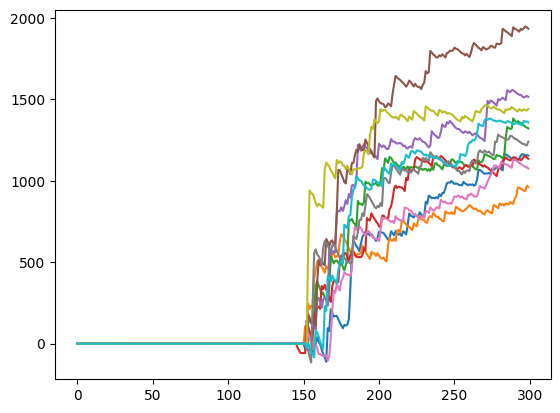

In [14]:
#final
S, S0 = train_params([0.2], [1.5], [1e-4])
plt.plot(S.T)
plt.show()

## Example 3: mean shift detection in a multivariate sequence.

### Score-based change point detector with linear basis $\Psi$ 

In [18]:
# function calculates the threshold and runs the algorithm with each set of hyperparameters in a loop
def train_params(eta_list, lambda_list, alpha_list, sigma, thrs_add=0):
    dim = 3
    mean = np.zeros(dim)
    cov = np.eye(dim)
    n = 300
    tau = 150
    runs = 10

    np.random.seed(1)
    for eta in eta_list:
        for l in lambda_list:
            for a in alpha_list:
                
                # threshold 
                S_0 = np.empty((runs-1, tau))
                for item in range(runs-1):
                    X = randmn(mean, cov, size=tau).reshape((tau, dim, 1)) * sigma[None, :, None]       
                    model = ChangePointDetector(d_dim=dim, x_dim=dim, lambda_=l, alpha=a, basis=PolyBasis(1, dim), reference_score=reference_score)
                    S, _ = model.run(X, eta)
                    S_0[item] = S
                    
                threshold = np.max(S_0) + thrs_add
                print('threshold = ', threshold)

                # detection of change points 
                S_list = np.empty((runs, n))
                for item in range(runs):
                    X = randmn(mean, cov, size=n).reshape((n, dim, 1)) * sigma[None, :, None]         
                    X[tau:] += 3*sigma[:, None]
                    model = ChangePointDetector(d_dim=dim, x_dim=dim, lambda_=l, alpha=a, basis=PolyBasis(1, dim), reference_score=reference_score)
                    S, _ = model.run(X, eta)
                    S_list[item] = S
                
                # computation of average delays and the number of false alarms
                false_alarms, mean_delay, std_delay, not_detected = compute_delays_false_alarms(runs, S_list, threshold, tau)
                print(f'eta = {np.round(eta, 4)}, lambda = {np.round(l, 4)}, alpha = {np.round(a, 4)}', ' False alarms:', false_alarms, 'DD : ', mean_delay, '±', std_delay, 'not detected: ', not_detected)
    return S_list


threshold =  0.01715607481874725
eta = 1, lambda = 5, alpha = 0.0  False alarms: 0 DD :  16.8 ± 1.2 not detected:  0
threshold =  0.01318203589618414
eta = 1, lambda = 5, alpha = 0.0001  False alarms: 0 DD :  10.9 ± 1.1 not detected:  0
threshold =  0.02608100736273585
eta = 1, lambda = 5, alpha = 0.001  False alarms: 0 DD :  7.3 ± 1.1 not detected:  0
threshold =  0.06414805272768424
65 9
eta = 1, lambda = 5, alpha = 0.01  False alarms: 1 DD :  4.1 ± 0.9 not detected:  0
threshold =  0.4369200241493658
eta = 1, lambda = 5, alpha = 0.05  False alarms: 0 DD :  4.7 ± 1.3 not detected:  0
threshold =  0.011779455326046425
eta = 1, lambda = 8, alpha = 0.0  False alarms: 0 DD :  16.1 ± 1.3 not detected:  0
threshold =  0.015541845899091236
eta = 1, lambda = 8, alpha = 0.0001  False alarms: 0 DD :  12.2 ± 1.2 not detected:  0
threshold =  0.01777868707388782
eta = 1, lambda = 8, alpha = 0.001  False alarms: 0 DD :  6.2 ± 1.2 not detected:  0
threshold =  0.04121401472867763
107 7
eta = 1, la

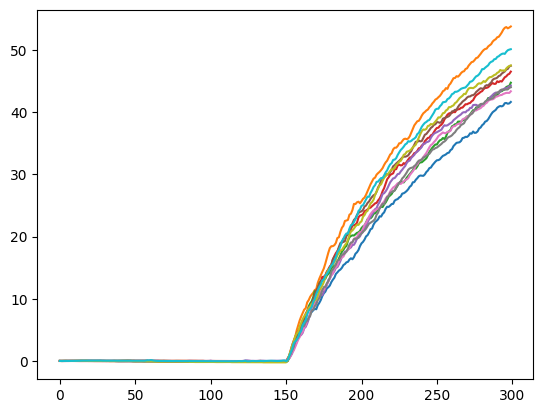

In [16]:
sigma = np.array([0.1, 0.2, 0.3])
S = train_params([1,1.5, 5, 8, 10 ], [5, 8, 10, 14], [1e-5, 1e-4, 1e-3, 1e-2, 5e-2], sigma=sigma, thrs_add = 0.01)
plt.plot(S.T)
plt.show()

threshold =  0.0658631983847003
eta = 10, lambda = 10, alpha = 0.001  False alarms: 0 DD :  1.9 ± 0.3 not detected:  0


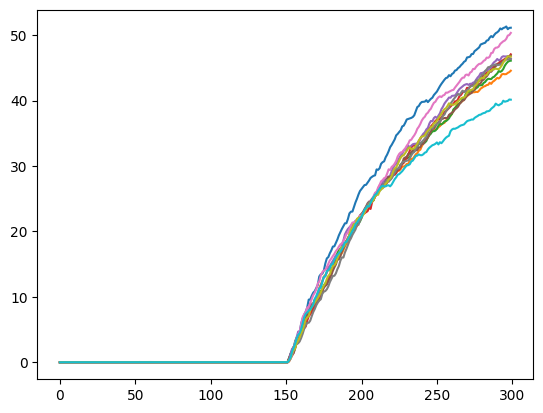

In [19]:
# final
sigma = np.array([0.1, 0.2, 0.3])
S = train_params([10], [10], [1e-3], sigma=sigma, thrs_add = 0.01)
plt.plot(S.T)
plt.show()

### Score-based change point detector with quadratic basis $\Psi$ 

In [27]:
# function calculates the threshold and runs the algorithm with each set of hyperparameters in a loop
def train_params(eta_list, lambda_list, alpha_list, sigma, thrs_add=0):
    dim = 3
    mean = np.zeros(dim)
    cov = np.eye(dim)
    n = 300
    tau = 150
    runs = 10

    np.random.seed(1)
    for eta in eta_list:
        for l in lambda_list:
            for a in alpha_list:
                
                # threshold 
                S_0 = np.empty((9, tau))
                for item in range(9):
                    X = randmn(mean, cov, size=tau).reshape((tau, dim, 1)) * sigma[None, :, None]       
                    model = ChangePointDetector(d_dim=dim*2, x_dim=dim, lambda_=l, alpha=a, basis=PolyBasis(2, dim))
                    S, _ = model.run(X, eta)
                    S_0[item] = S
                    
                threshold = np.max(S_0) + thrs_add
                print('threshold = ', threshold)

                # detection of change points 
                S_list = np.empty((runs, n))
                for item in range(runs):
                    X = randmn(mean, cov, size=n).reshape((n, dim, 1)) * sigma[None, :, None]         
                    X[tau:] += 3*sigma[:, None]
                    model = ChangePointDetector(d_dim=dim*2, x_dim=dim, lambda_=l, alpha=a, basis=PolyBasis(2, dim))
                    S, _ = model.run(X, eta)
                    S_list[item] = S

                 # computation of average delays and the number of false alarms
                false_alarms, mean_delay, std_delay, not_detected = compute_delays_false_alarms(runs, S_list, threshold, tau)
                print(f'eta = {np.round(eta, 4)}, lambda = {np.round(l, 4)}, alpha = {np.round(a, 5)}', ' False alarms:', false_alarms, 'DD : ', mean_delay, '±', std_delay, 'not detected: ', not_detected)
    return S_list


threshold =  47.86569677397847
eta = 0.8, lambda = 1.4, alpha = 0.0  False alarms: 0 DD :  2.2 ± 0.7 not detected:  0
threshold =  26.774609532889826
1 7
1 9
eta = 0.8, lambda = 1.5, alpha = 0.0  False alarms: 2 DD :  2.2 ± 0.8 not detected:  0
threshold =  29.49421370558457
eta = 0.8, lambda = 1.6, alpha = 0.0  False alarms: 0 DD :  2.3 ± 0.9 not detected:  0


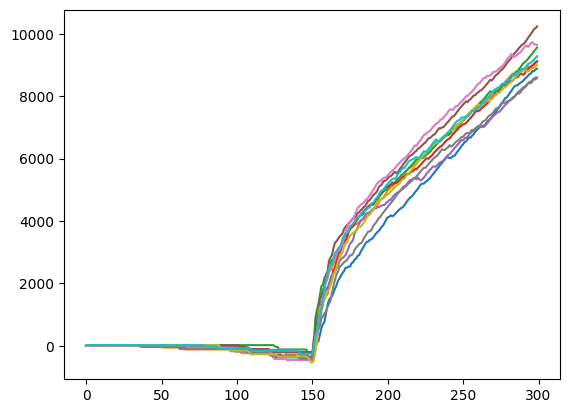

In [24]:
sigma = np.array([0.1, 0.2, 0.3])
S = train_params([ 0.8], [1.4], [1e-7], sigma=sigma, thrs_add = 0)
S = train_params([ 0.8], [1.5], [1e-7], sigma=sigma, thrs_add = 0)
S = train_params([ 0.8], [ 1.6], [1e-7], sigma=sigma, thrs_add = 0)

plt.plot(S.T)
plt.show()

threshold =  29.49421370558457
eta = 0.8, lambda = 1.6, alpha = 0.0  False alarms: 0 DD :  2.3 ± 0.9 not detected:  0


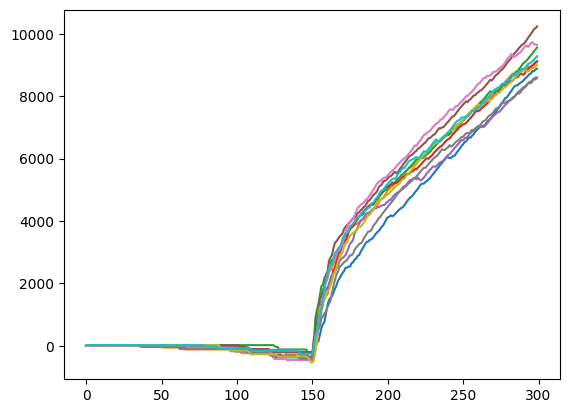

In [28]:
# final
sigma = np.array([0.1, 0.2, 0.3])
S = train_params([0.8], [ 1.6], [1e-7], sigma=sigma, thrs_add = 0)

plt.plot(S.T)
plt.show()

## Example 4: variance shift detection in a multivariate sequence. 

### Score-based change point detector with quadratic basis $\Psi$ 

In [32]:
# function calculates the threshold and runs the algorithm with each set of hyperparameters in a loop
def train_params(eta_list, lambda_list, alpha_list, sigma1, sigma2, thrs_add=0):
    dim = 3
    mean = np.zeros(dim)
    cov = np.eye(dim)
    n = 300
    tau = 150
    runs = 10

    np.random.seed(1)
    for eta in eta_list:
        for l in lambda_list:
            for a in alpha_list:
                
                # threshold 
                S_0 = np.empty((2*runs-1, tau))
                for item in range(2*runs-1):
                    X = randmn(mean, cov, size=tau).reshape((tau, dim, 1)) * sigma1[None, :, None]       
                    model = ChangePointDetector(d_dim=dim*2, x_dim=dim, lambda_=l, alpha=a, basis=PolyBasis(2, dim))
                    S, _ = model.run(X, eta)
                    S_0[item] = S
                    
                threshold = np.max(S_0) + thrs_add
                print('threshold = ', threshold)

                # detection of change points 
                S_list = np.empty((runs, n))
                for item in range(runs):
                    X = randmn(mean, cov, size=n).reshape((n, dim, 1)) 
                    X[:tau] *= sigma1[None, :, None]       
                    X[tau:] *= sigma2[None, :, None] 
                    model = ChangePointDetector(d_dim=dim*2, x_dim=dim, lambda_=l, alpha=a, basis=PolyBasis(2, dim))
                    S, _ = model.run(X, eta)
                    S_list[item] = S

                # computation of average delays and the number of false alarms
                false_alarms, mean_delay, std_delay, not_detected = compute_delays_false_alarms(runs, S_list, threshold, tau)
                print(f'eta = {np.round(eta, 4)}, lambda = {np.round(l, 4)}, alpha = {np.round(a, 5)}', ' False alarms:', false_alarms, 'DD : ', mean_delay, '±', std_delay, 'not detected: ', not_detected)
    return S_list


In [15]:
sigma1 = np.array([0.1, 0.2, 0.3])
sigma2 = np.array([0.3, 0.6, 0.9])

S = train_params([1], [1.5], [1e-7], sigma1=sigma1, sigma2=sigma2)
S = train_params([0.7], [1.5], [1e-5], sigma1=sigma1, sigma2=sigma2)
S = train_params([0.5], [1.5], [1e-5], sigma1=sigma1, sigma2=sigma2)
S = train_params([0.3], [1.5], [1e-5], sigma1=sigma1, sigma2=sigma2)

threshold =   123.92824145462669
eta = 1, lambda = 1.5, alpha = 0.0  False alarms: 0 DD :  4.1 ± 3.6 not detected:  0
threshold =  126.79673831755645
eta = 0.7, lambda = 1.5, alpha = 0.00001  False alarms: 0 DD :  3.0 ± 1.9 not detected:  0
threshold =  96.91279655701055
eta = 0.5, lambda = 1.5, alpha = 0.00001  False alarms: 0 DD :  2.5 ± 1.7 not detected:  0
threshold = 11.924405105177357
eta = 0.3, lambda = 1.5, alpha = 0.00001  False alarms: 0 DD :  2.1 ± 1.7 not detected:  0



threshold =  11.924405105177357
eta = 0.3, lambda = 1.5, alpha = 1e-05  False alarms: 0 DD :  2.1 ± 1.7 not detected:  0


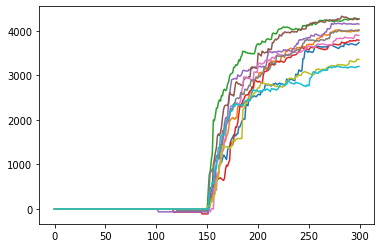

In [31]:
#final

sigma1 = np.array([0.1, 0.2, 0.3])
sigma2 = np.array([0.3, 0.6, 0.9])
S = train_params([0.3], [1.5], [1e-5], sigma1=sigma1, sigma2=sigma2)
plt.plot(S.T)
plt.show()